# Figures for 2019 ADAP Proposal

* Magnitude-surface brightness with notable large galaxies labeled
* Show color-magnitude space with Tractor mag/color and custom (aperture) mag/color.
* Need for this analysis:
  - Where does the Tractor pipeline break down?
  - Which galaxies require custom analysis?

In [1]:
import os, warnings, pdb
from glob import glob
import numpy as np
import pandas as pd

import fitsio
from astropy.table import Table, Column, vstack, hstack

In [173]:
import corner
import matplotlib.pyplot as plt
import matplotlib as mpl

In [3]:
from LSLGA.io import read_parent

In [4]:
import seaborn as sns
sns.set(style='ticks', font_scale=1.8, palette='Set2')
%matplotlib inline

In [5]:
LSLGAdir = os.getenv('LSLGA_DIR')
#adapdir = os.path.join(os.getenv('HOME'), 'repos', 'papers', 'grants', 'nasa-adap-2019')
adapdir = os.path.join(LSLGAdir, 'science', 'proposals', 'nasa-adap-2019')

In [6]:
PIXSCALE = 0.262

In [7]:
seed = 1
rand = np.random.RandomState(seed)

In [8]:
#leda = Table.read(os.path.join(LSLGAdir, 'sample', 'hyperleda-d25min10-18may13.fits'))
#parent = Table.read(os.path.join(LSLGAdir, 'sample', 'large-galaxies-parent.fits'))

### Read dr8b catalogs in the EDR and cross-match with the parent LSLGA.

In [9]:
lslga = read_parent(verbose=True)
lslga[:3]

Read galaxy indices 0 through 532706 (N=532707) from /Users/ioannis/research/projects/LSLGA/sample/v2.0/LSLGA-v2.0.fits


LSLGA_ID,GALAXY,PGC,RA,DEC,TYPE,BAR,RING,MULTIPLE,COMPACTNESS,T,PA,D25,BA,DIAM_REF,Z,SB_D25,MAG,MAG_REF,WISE_RA,WISE_DEC,CNTR,W1MPRO,W1SIGMPRO,W2MPRO,W2SIGMPRO,W3MPRO,W3SIGMPRO,W4MPRO,W4SIGMPRO,RCHI2,CC_FLAGS,EXT_FLG,PH_QUAL,XSCPROX,W1RSEMI,W1BA,W1PA,W1GMAG,W1GERR,W2GMAG,W2GERR,W3GMAG,W3GERR,W4GMAG,W4GERR,IN_ALLWISE,IN_DESI,NEAR_BRIGHTSTAR
int64,bytes29,int64,float64,float64,bytes4,bytes3,bytes3,bytes3,bytes3,float32,float32,float32,float32,bytes3,float32,float32,float32,bytes1,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float32,bytes4,int32,bytes4,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bool,bool,bool
2,PGC1283207,1283207,228.3770865,5.4232017,S?,nan,nan,nan,nan,0.9,152.2,0.36307806,0.724436,iso,0.03463229,23.40448,16.976,B,228.3771822,5.4228275,2278106001351000050,13.453,0.039,13.393,0.045,11.785,0.242,8.741,nan,1.088,0000,4,AABU,0.95,9.75,0.73,-25.0,13.27,0.01,13.334,0.02,12.209,0.183,10.103,0.835,True,True,False
3,PGC1310416,1310416,202.54443750000002,6.9345944,Sc,nan,nan,M,nan,4.7,159.26,0.4017908,0.7816278,iso,0.073888786,23.498482,16.85,B,202.5444539,6.9345167,2028107501351007858,13.282,0.025,13.109,0.028,9.197,0.03,7.024,0.098,2.075,0000,5,AAAA,0.51,9.36,0.79,-10.0,13.214,0.01,13.069,0.021,9.695,0.024,7.485,0.104,True,True,False
4,SDSSJ145059.93+135143.0,4435547,222.749787,13.8619111,S?,nan,nan,nan,nan,5.0,44.57,0.33342642,0.6637431,iso,0.07567602,24.457481,18.214,B,222.7496762,13.8620163,2234113601351039304,14.829,0.029,14.596,0.049,11.637,0.165,8.57,nan,1.155,0000,0,AABU,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,True,True,False


In [288]:
def read_tractor(camera='decam', snrcut=5, rmagcut=22, reffmin=0.1, clobber=False):
    """Read the Tractor catalogs and apply some sensible cuts.
    
    """
    outfile = os.path.join(adapdir, 'tractor-edr-{}.fits'.format(camera))
    if os.path.isfile(outfile) and not clobber:
        cat = Table.read(outfile)
        print('Read {} galaxies from {}.'.format(len(cat), outfile))
        return cat
        
    def get_outtable(ngal):
        out = Table()
        out.add_column(Column(name='galaxy', length=ngal, dtype='S29'))
        out.add_column(Column(name='brickname', length=ngal, dtype='S8'))
        out.add_column(Column(name='ra', length=ngal, dtype='f8'))
        out.add_column(Column(name='dec', length=ngal, dtype='f8'))
        out.add_column(Column(name='ra_lslga', length=ngal, dtype='f8'))
        out.add_column(Column(name='dec_lslga', length=ngal, dtype='f8'))
        out.add_column(Column(name='brightblob', length=ngal, dtype='>i2'))
        out.add_column(Column(name='fracdev', length=ngal, dtype='f4'))
        out.add_column(Column(name='rmag', length=ngal, dtype='f4'))
        out.add_column(Column(name='gr', length=ngal, dtype='f4'))
        out.add_column(Column(name='rz', length=ngal, dtype='f4'))
        out.add_column(Column(name='sb', length=ngal, dtype='f4'))
        out.add_column(Column(name='reff', length=ngal, dtype='f4'))
        out.add_column(Column(name='ref_cat', length=ngal, dtype='S2'))
        out.add_column(Column(name='type', length=ngal, dtype='S4'))
        out.add_column(Column(name='morphtype', length=ngal, dtype='S4'))
        return out
    
    dr8dir = os.path.join(os.getenv('IM_WORK_DIR'), 'legacysurvey', 'dr8b')
    allout = []
    
    # EDR region
    catfile = glob(os.path.join(dr8dir, camera, 'tractor', '24?', 'tractor*.fits'))
    allcat = []
    for ii, ff in enumerate(catfile):
        if ii % 100 == 0:
            print('{} / {}'.format(ii, len(catfile)))
        cc = Table(fitsio.read(ff, upper=True,
                               columns=['BRICK_PRIMARY', 'BRIGHTBLOB',
                                        #'MASKBITS', 
                                        'BRICKNAME', 'RA', 'DEC', 'REF_CAT', 'REF_ID', 'TYPE', 'FRACDEV',
                                        'SHAPEEXP_R', 'SHAPEEXP_E1', 'SHAPEEXP_E2', 
                                        'SHAPEDEV_R', 'SHAPEDEV_E1', 'SHAPEDEV_E2',
                                        'FLUX_G', 'FLUX_R', 'FLUX_Z', 'FLUX_IVAR_G', 'FLUX_IVAR_R', 'FLUX_IVAR_Z']))
        allcat.append(cc)
    allcat = vstack(allcat)
        
    # Apply S/N and morphology cuts.
    if True:
        allreff = (allcat['FRACDEV'] * allcat['SHAPEDEV_R'] + (1-allcat['FRACDEV']) * allcat['SHAPEEXP_R'])
    else:
        allreff = np.max(np.vstack((allcat['SHAPEDEV_R'], allcat['SHAPEEXP_R'])), axis=0)
    
    indx = np.where(
        allcat['BRICK_PRIMARY'] * # primary
        ((allcat['BRIGHTBLOB'] & 0x1) == 0) * # not in bright star
        ((allcat['BRIGHTBLOB'] & 0x2) == 0) * # not in medium-bright star
        ((allcat['BRIGHTBLOB'] & 0x4) == 0) * # not in globular cluster
        #((allcat['MASKBITS'] & 0x1) != 0) *    # primary
        #((allcat['MASKBITS'] & 0x2) != 0) *    # not in bright star
        #((allcat['MASKBITS'] & 0x800) != 0) *  # not in medium-bright star
        #((allcat['MASKBITS'] & 0x2000) != 0) * # not in globular cluster
        (allcat['TYPE'] != 'PSF ') * (allcat['TYPE'] != 'REX ') * (allreff > reffmin) * 
        (allcat['FLUX_G'] > 0) * (allcat['FLUX_G']*allcat['FLUX_IVAR_G'] > snrcut) *
        (allcat['FLUX_R'] > 0) * (allcat['FLUX_R']*allcat['FLUX_IVAR_R'] > snrcut) *
        (allcat['FLUX_Z'] > 0) * (allcat['FLUX_Z']*allcat['FLUX_IVAR_Z'] > snrcut) *
        (allcat['FLUX_R'] > 10**(0.4*(22.5-rmagcut))) )[0]
    print('S/N & morphology cuts: {}/{}'.format(len(indx), len(allcat)))
    
    cat = allcat[indx]
    
    ilargegal = np.where(cat['REF_CAT'] == 'L2')[0] # LSLGA
    ilargegal = ilargegal[np.argsort(cat['REF_ID'][ilargegal])] # sort
    print('Found {}/{} large galaxies).'.format(len(ilargegal), len(cat)))

    # magnitudes and colors
    gmag = 22.5-2.5*np.log10(cat['FLUX_G'])
    rmag = 22.5-2.5*np.log10(cat['FLUX_R'])
    zmag = 22.5-2.5*np.log10(cat['FLUX_Z'])
       
    # mean galaxy size
    if True:
        reff = (cat['FRACDEV'] * cat['SHAPEDEV_R'] + (1-cat['FRACDEV']) * cat['SHAPEEXP_R'])
    else:
        reff = np.max(np.vstack((cat['SHAPEDEV_R'], cat['SHAPEEXP_R'])), axis=0)

    # mean surface brightness (e.g., Strauss+02)
    sb = rmag + 2.5 * np.log10(2 * np.pi * reff**2)

    out = get_outtable(len(cat))
    out['brickname'] = cat['BRICKNAME']
    out['ra'] = cat['RA']
    out['dec'] = cat['DEC']
    out['ref_cat'] = cat['REF_CAT']
    out['brightblob'] = cat['BRIGHTBLOB']
    #out['ref_id'] = cat['REF_ID']
    out['type'] = cat['TYPE']
    out['fracdev'] = cat['FRACDEV']
    out['rmag'] = rmag
    out['gr'] = gmag - rmag
    out['rz'] = rmag - zmag
    out['reff'] = reff
    out['sb'] = sb
        
    # Now match to the LSLGA
    if len(ilargegal) > 0:
        lkeep = np.where(np.isin(lslga['LSLGA_ID'], cat['REF_ID'][ilargegal]))[0]
        assert(np.all(lslga['LSLGA_ID'][lkeep] == cat['REF_ID'][ilargegal]))
        print(len(ilargegal), len(lkeep))
        out['galaxy'][ilargegal] = lslga['GALAXY'][lkeep]
        out['ra_lslga'][ilargegal] = lslga['RA'][lkeep]
        out['dec_lslga'][ilargegal] = lslga['DEC'][lkeep]
        out['morphtype'][ilargegal] = lslga['TYPE'][lkeep]

    print('Writing {} galaxies to {}.'.format(len(out), outfile))
    out.write(outfile, overwrite=True)
        
    return out

In [289]:
cat = read_tractor(clobber=False)

0 / 517
100 / 517
200 / 517
300 / 517
400 / 517
500 / 517
S/N & morphology cuts: 152303/3206438
Found 248/152303 large galaxies).
248 248
Writing 152303 galaxies to /Users/ioannis/research/projects/LSLGA/science/proposals/nasa-adap-2019/tractor-edr-decam.fits.


In [290]:
cat[cat['ref_cat'] == 'L2']

galaxy,brickname,ra,dec,ra_lslga,dec_lslga,brightblob,fracdev,rmag,gr,rz,sb,reff,ref_cat,type,morphtype
bytes29,bytes8,float64,float64,float64,float64,int16,float32,float32,float32,float32,float32,float32,bytes2,bytes4,bytes4
2MASXJ16082984+0957094,2422p100,242.12444118388387,9.952691359018258,242.124411,9.9527087,8,0.0,16.875118,0.83761406,0.6953678,22.236628,4.712071,L2,EXP,SBd
2MASXJ16084802+0552537,2421p060,242.200038805405,5.881513295056489,242.20010700000003,5.881521299999999,8,0.06969493,16.330662,0.77668,0.6213856,21.366112,4.0550866,L2,COMP,Sbc
PGC3091859,2421p060,242.25118957471688,6.089672883294036,242.251284,6.0896444,8,0.0,15.584602,0.73596764,0.5869436,20.754395,4.313885,L2,EXP,Sb
PGC1364418,2421p095,242.14805589984508,9.390446895443523,242.148171,9.390418400000001,8,0.0,17.253136,0.82826424,0.7022438,23.028818,5.7022557,L2,EXP,E?
2MASXJ16090286+0722260,2423p072,242.26188383815858,7.373927255947278,242.26191450000002,7.373899900000001,8,0.0,17.18816,0.9005604,0.81814003,22.664875,4.968816,L2,EXP,E?
UGC10225,2423p087,242.33636930349581,8.763213717429995,242.33641649999998,8.7632727,8,0.0,13.929474,0.55447006,0.41689587,22.243181,18.350655,L2,EXP,Sd
PGC1353920,2423p087,242.22443281038414,8.799657000317197,242.22448499999996,8.7996117,8,0.0,17.675774,0.6175842,0.49270248,22.09547,3.0538628,L2,EXP,nan
PGC1317761,2428p072,242.80270820897238,7.270580714706767,242.802669,7.270635,8,0.0,16.312868,0.6226959,0.4906807,21.48454,4.317622,L2,EXP,SBbc
2MASXJ16080337+0458488,2420p050,242.01415240814163,4.980126364152614,242.01413849999997,4.980181,8,0.12499756,16.02348,0.99407196,0.8112545,21.623268,5.2585735,L2,COMP,S?


In [302]:
ww = np.where(['NGC' in gg or 'UGC' in gg for gg in cat['galaxy']])[0]
cat[ww]

galaxy,brickname,ra,dec,ra_lslga,dec_lslga,brightblob,fracdev,rmag,gr,rz,sb,reff,ref_cat,type,morphtype
bytes29,bytes8,float64,float64,float64,float64,int16,float32,float32,float32,float32,float32,float32,bytes2,bytes4,bytes4
UGC10225,2423p087,242.33636930349581,8.763213717429995,242.33641649999998,8.7632727,8,0.0,13.929474,0.55447006,0.41689587,22.243181,18.350655,L2,EXP,Sd
NGC6081,2432p097,243.23693362319557,9.867077035066131,243.2368935,9.867104800000002,8,0.688309,12.741571,0.87629414,0.8007536,20.896103,17.053606,L2,COMP,S0
UGC10158,2410p117,240.9806684427746,11.72866372643585,240.98060549999997,11.7286425,8,1.0,13.284298,0.9686394,0.735837,21.874443,20.84198,L2,DEV,S0
UGC10213,2418p105,241.85452056376354,10.425767294285151,241.85459099999997,10.4257967,8,0.0,14.005193,0.6534281,0.51690483,21.638115,13.412034,L2,EXP,Sbc
UGC10137,2404p082,240.457156451889,8.148263591416356,240.4571535,8.1482709,8,0.21976142,14.1258335,0.6369276,0.49136353,22.575245,19.534048,L2,COMP,Sc
UGC10146,2407p050,240.77107901921576,5.107847968860165,240.7709985,5.1078025,8,0.0,15.096817,0.626359,0.48442173,22.77604,13.701065,L2,EXP,Sm
UGC10130,2402p087,240.333275246809,8.835932463550856,240.33329849999998,8.8359551,8,0.22669081,13.7252865,0.7151861,0.57232475,21.276356,12.915874,L2,COMP,SBa


In [409]:
def qa_rmag_sb(cat, png=None):
    """Surface brightness vs r-band magnitude.
    
    """
    xlim, ylim = (12, 22), (18, 28)

    fig, ax = plt.subplots(figsize=(8, 6))
    corner.hist2d(cat['rmag'], cat['sb'], levels=[0.01, 0.05, 0.25, 0.5, 0.75, 0.95, 0.99],
                  bins=100, smooth=True, color='tan', # mpl.cm.get_cmap('viridis'),
                  plot_density=True, fill_contours=True,
                  data_kwargs={'color': 'navy', 'alpha': 0.8, 'ms': 2},
                  contour_kwargs={'colors': 'k'}
                 )
           
    # overplot lines of constant size
    magarr = np.linspace(xlim[0], xlim[1], 50)
    for size, ypos in zip((0.3, 1, 3, 10, 30, 100),
                          (18.8, 18.8, 18.8, 20.2, 22.7, 25.2)):
        sbarr = magarr + 2.5 * np.log10(2 * np.pi * size**2)
        ax.plot(magarr, sbarr, color='k', lw=2, ls='--', alpha=0.5)
        
        xpos = ypos - 2.5 * np.log10(2 * np.pi * size**2) - 1
        #print(size, xpos, ypos)
        #if size == 
        ax.text(xpos, ypos, r'$r_{{50}}={0:g}^{{\prime\prime}}$'.format(size), 
                ha='left', va='center', rotation=35, fontsize=14, alpha=0.5)

    check = np.where( (cat['sb'] > cat['rmag']+2.5*np.log10(np.pi*10**2)) * (cat['rmag'] < 18) )[0]
    print(len(check), len(cat))
    #ax.scatter(cat['rmag'][check], cat['sb'][check], color='blue', marker='s', s=10)
    #for ii, cc in enumerate(check[:30]):
    #    print('gal{}'.format(ii), cat['ra'][cc], cat['dec'][cc], cat['reff'][cc], 
    #          cat['rmag'][cc], cat['type'][cc], cat['brightblob'][cc] & 0x2)
    
    lgal = cat['ref_cat'] == 'L2'
    ax.scatter(cat['rmag'][lgal], cat['sb'][lgal], marker='s', edgecolors='k', s=30, 
               alpha=0.5, lw=1, color='firebrick')
    
    #ingc = np.where(['NGC' in gg or 'UGC' in gg for gg in cat['galaxy']])[0]
    #ax.scatter(cat['rmag'][ingc], cat['sb'][ingc], marker='s', edgecolors='k', s=30, 
    #           alpha=0.5, lw=1, color='firebrick')
    
    ingc = np.where(['NGC' in gg for gg in cat['galaxy']])[0]
    #print(cat[ingc])
    #for ii in ingc:
    #    ax.text(cat['rmag'][ii], cat['sb'][ii], cat['galaxy'][ii], 
    #            ha='left', va='bottom', fontsize=20)
    
    # labels and all that
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    #ax.xmargins(0)
    ax.set_xlabel(r'$m_{r}$ (mag)')
    ax.set_ylabel(r'$\mu_{50,r}$ (mag arcsec$^{-2}$)')
    
    fig.subplots_adjust(bottom=0.15, top=0.95, right=0.95)
    
    if png:
        pngfile = os.path.join(adapdir, png)
        print('Writing {}'.format(pngfile))
        fig.savefig(pngfile)

199 152303
Writing /Users/ioannis/research/projects/LSLGA/science/proposals/nasa-adap-2019/sb-mag.png


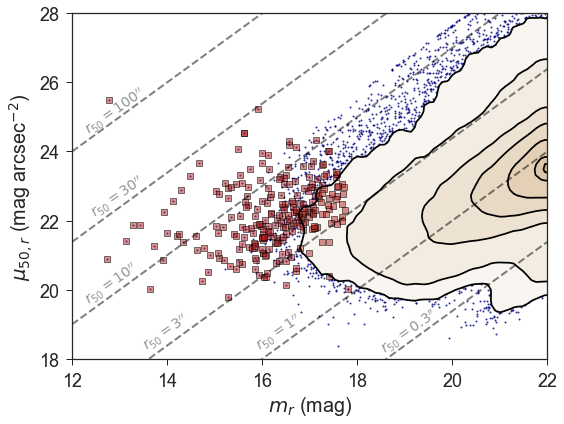

In [410]:
qa_rmag_sb(cat, png='sb-mag.png')

In [124]:
def make_montage(infiles):
    montagefile = os.path.join(adapdir, 'centrals-gallery.png')

    ncol = 8
    nrow = 6
    
    cmd = 'montage -bordercolor white -borderwidth 1 -tile {}x{} -geometry 512x512 '.format(ncol, nrow)
    cmd = cmd+' '.join([inff for inff in infiles])
    cmd = cmd+' {}'.format(montagefile)
    #print(cmd)
    os.system(cmd)        
    print('Writing {}'.format(montagefile))

0.005560343795637913

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))
ipsf = ipsf[:1000]
igal = igal[:1000]
extent = (-0.5, 2.5, -0.5, 2.5)
#ax.hexbin(rmag[ipsf]-zmag[ipsf], gmag[ipsf]-rmag[ipsf], bins='log', mincnt=50)
sns.kdeplot(rmag[ipsf]-zmag[ipsf], gmag[ipsf]-rmag[ipsf], ax=ax, extent=extent, cbar=True)
sns.kdeplot(rmag[igal]-zmag[igal], gmag[igal]-rmag[igal], ax=ax, extent=extent)
#sns.rugplot(gmag[ipsf]-rmag[ipsf], color="g", ax=ax)
#ax.hexbin(rmag-zmag, gmag-rmag, bins='log', mincnt=1)
ax.set_xlim(extent[:2])
ax.set_ylim(extent[2:4])

In [ ]:
ww = allcat['FLUX_R'] > 10**(0.4*(22.5-23))
_ = plt.hist(22.5-2.5*np.log10(allcat['FLUX_R'][ww]), bins=20, normed=True)
_ = plt.hist(22.5-2.5*np.log10(lslgacat['FLUX_R']), bins=20, normed=True)

### Multiwavelength surface-brightness profile for one galaxy

NGC5322, a massive elliptical
```bash
salloc -N 1 -C haswell -t 00:60:00 --qos interactive -L SCRATCH,project
source ~/software/develop-legacysurveys-code

wise-galex-cutouts -r 207.313452 -d 60.1904759 --radius 600 --prefix NGC5322 \
  --survey-dir /global/projecta/projectdirs/cosmo/data/legacysurvey/dr6
```

In [ ]:
def do_sbprofiles(galaxy='NGC5322'):
    """Measure the surface brightness profile in all the bandpasses
    
    """
    ellipsefit = dict()
    for band, scale in zip( ['FUV', 'NUV', 'g', 'r', 'z', 'W1', 'W2', 'W3', 'W4'],
                            [0.2, 0.2, 0.262, 0.262, 0.262, 1.375, 1.375, 1.375, 1.375] ):
    #for band in ['g', 'r', 'z', 'W1', 'W2', 'W3', 'W4']:
        ellipsefit[band] = fitsio.read(os.path.join(adapdir, 'sbprofiles', '{}-{}-image.fits'.format(
            galaxy, band))) / scale**2
    
    # Use W1 as the reference image for getting the geometry
    img = ellipsefit['W1']
    gal = find_galaxy(img, nblob=1, binning=3, plot=True, quiet=False)
    
    geometry = EllipseGeometry(x0=gal.xpeak, y0=gal.ypeak, eps=gal.eps,
                               sma=5, pa=np.radians(gal.pa-90))    
    ellipse = Ellipse(img, geometry=geometry)
    
    integrmode, sclip, nclip, step, fflag = 'bilinear', 3, 0, 0.1, 0.5
    isophot = ellipse.fit_image(minsma=1.0, maxsma=3*gal.majoraxis,
                                integrmode=integrmode, sclip=sclip, nclip=nclip,
                                step=step, fflag=fflag)
    ellipsefit['ref_isophot'] = isophot
    
    for band in ['FUV', 'NUV', 'g', 'r', 'z', 'W1', 'W2', 'W3', 'W4']:
        img = ellipsefit[band]
        isobandfit = []
        for iso in isophot:
            g = iso.sample.geometry # fixed geometry

            # Use the same integration mode and clipping parameters.
            sample = EllipseSample(img, g.sma, geometry=g, integrmode=integrmode,
                                   sclip=sclip, nclip=nclip)
            sample.update()

            # Create an Isophote instance with the sample.
            isobandfit.append(Isophote(sample, 0, True, 0))

        ellipsefit['{}_isophot'.format(band)] = IsophoteList(isobandfit)
        
    return ellipsefit

In [ ]:
def qa_sbprofiles(ellipsefit, png=None):
    
    fig, ax = plt.subplots(figsize=(8, 6))
    for band in ['FUV', 'NUV', 'g', 'r', 'z', 'W1', 'W2', 'W3', 'W4']:
        flux = ellipsefit['{}_isophot'.format(band)].intens
        
        good = (ellipsefit['{}_isophot'.format(band)].stop_code < 4) * (flux > 0)
        sma = ellipsefit['ref_isophot'].sma[good] * PIXSCALE
        flux = ellipsefit['{}_isophot'.format(band)].intens[good]
        ferr = ellipsefit['{}_isophot'.format(band)].int_err[good]

        mu = 22.5 - 2.5 * np.log10(flux)
        mu_err = ferr / flux / np.log(10)
        mu_err[mu_err < 0.1] = 0.1
        print(band, mu.min(), mu.max())
        
        ax.fill_between(sma, mu - mu_err, mu + mu_err, alpha=0.8)
        #ax.axhline(y=WISE['mulim_{}'.format(suffix)], lw=2, color='k', ls='--')
        
    #ax.legend(loc='upper right')
    #ax.margins(0)
    ax.set_ylim(35, 8)
    #ax.set_xlim(0.4, 1.5)
    
    #ax.set_xscale('log')
    ax.set_xlabel(r'Semi-major axis (arcsec)')
    #ax.set_xlabel(r'(Galactocentric Radius)$^{1/4}$ (arcmin)')
    ax.set_ylabel(r'Surface Brightness (mag arcsec$^{-2}$)')
    
    if png:
        fig.savefig(png)

In [ ]:
qa_sbprofiles(ellipsefit, png=None)

In [ ]:
%time ellipsefit = do_sbprofiles(galaxy='NGC5322')

In [ ]:
stop

### Compare the unWISE vs WISE+NEO4 surface-brightness profile for one galaxy

Demonstrate the improved depth of the NEO4 data vs unWISE by generating the azimuthally averaged surface brightness profile in W1 and W2.

```bash

salloc -N 1 -C haswell -t 00:60:00 --qos interactive -L SCRATCH,project
source ~/software/develop-legacysurveys-code

export UNWISE_COADDS_DIR=/global/cscratch1/sd/ameisner/unwise-coadds/fulldepth_neo4:/global/project/projectdirs/cosmo/data/unwise/allwise/unwise-coadds/fulldepth
wise-galex-cutouts -r 207.313452 -d 60.1904759 --radius 720 --survey-dir /global/projecta/projectdirs/cosmo/data/legacysurvey/dr6 --prefix NGC5322 

export UNWISE_COADDS_DIR=/global/project/projectdirs/cosmo/data/unwise/allwise/unwise-coadds/fulldepth
wise-galex-cutouts -r 207.313452 -d 60.1904759 --radius 720 --survey-dir /global/projecta/projectdirs/cosmo/data/legacysurvey/dr6 --prefix NGC5322-AllWISE

```

In [ ]:
def wise_ellipsefit():
    """Measure the surface brightness profile in all the bandpasses
    
    """
    WISE = dict()
    WISE['W1deep'] = fitsio.read(os.path.join(adapdir, 'wise-sbprofiles', 'NGC5322-W1-image.fits'))
    WISE['W1shallow'] = fitsio.read(os.path.join(adapdir, 'wise-sbprofiles', 'NGC5322-AllWISE-W1-image.fits'))
    
    # Get the surface brightness limit for each image.
    img = WISE['W1deep']
    mask = make_source_mask(img, snr=2, npixels=5, dilate_size=11)
    
    for suffix in ('deep', 'shallow'):
        img = WISE['W1{}'.format(suffix)]
        mean, median, std = sigma_clipped_stats(img, sigma=3.0, mask=mask)
        WISE['mulim_{}'.format(suffix)] = 22.5 - 2.5 * np.log10(5 * std)
        print(WISE['mulim_{}'.format(suffix)])
    
    # Get the geometry of the galaxy.
    img = WISE['W1deep']
    gal = find_galaxy(img, nblob=1, binning=3, plot=False, quiet=True)
    geometry = EllipseGeometry(x0=gal.xpeak, y0=gal.ypeak, eps=gal.eps,
                               sma=5, pa=np.radians(gal.pa-90))    
    ellipse = Ellipse(img, geometry=geometry)
    
    integrmode, sclip, nclip, step, fflag = 'bilinear', 3, 0, 0.1, 0.5
    isophot = ellipse.fit_image(minsma=1.0, maxsma=3*gal.majoraxis,
                                integrmode=integrmode, sclip=sclip, nclip=nclip,
                                step=step, fflag=fflag)
    WISE['isophot_deep'] = isophot
    
    img = WISE['W1shallow']
    isobandfit = []
    for iso in isophot:
        g = iso.sample.geometry # fixed geometry

        # Use the same integration mode and clipping parameters.
        sample = EllipseSample(img, g.sma, geometry=g, integrmode=integrmode,
                               sclip=sclip, nclip=nclip)
        sample.update()

        # Create an Isophote instance with the sample.
        isobandfit.append(Isophote(sample, 0, True, 0))

    WISE['isophot_shallow'] = IsophoteList(isobandfit)
        
    return WISE

def wise_sbprofile(WISE, png=None):
    sma = WISE['isophot_deep'].sma / 60
    
    fig, ax = plt.subplots(figsize=(8, 6))
    for label, suffix in zip( ('WISE', 'WISE+NEO4'), ('shallow', 'deep') ):
        mu = 22.5 - 2.5 * np.log10(WISE['isophot_{}'.format(suffix)].intens)
        mu_err = WISE['isophot_{}'.format(suffix)].int_err / WISE['isophot_{}'.format(suffix)].intens / np.log(10)
        mu_err[mu_err < 0.1] = 0.1
        
        ax.fill_between(sma**0.25, mu - mu_err, mu + mu_err, label=label, alpha=0.8)
        ax.axhline(y=WISE['mulim_{}'.format(suffix)], lw=2, color='k', ls='--')
        
    #for suffix in ('shallow', 'deep'):
    #    ax.axhline(y=WISE['mulim_{}'.format(suffix)], color='k', lw=2)
    
    ax.legend(loc='upper right')
    #ax.margins(0)
    ax.set_ylim(22, 11)
    ax.set_xlim(0.4, 1.5)
    
    #ax.set_xscale('log')
    ax.set_xlabel(r'$R^{1/4}$ (arcmin)')
    #ax.set_xlabel(r'(Galactocentric Radius)$^{1/4}$ (arcmin)')
    ax.set_ylabel(r'Surface Brightness (mag arcsec$^{-2}$)')
    
    if png:
        fig.savefig(png)

In [ ]:
%time WISE = wise_ellipsefit()

In [ ]:
wise_sbprofile(WISE, png=os.path.join(adapdir, 'wise-sbprofiles.png'))

### Example of Tractor fitting

```bash
salloc -N 1 -C haswell -t 00:60:00 --qos interactive -L SCRATCH,project
source ~/software/develop-legacysurveys-code

wise-galex-cutouts -r 212.1947 -d 9.8785 --radius 180 --prefix tractor \
  --survey-dir /global/project/projectdirs/cosmo/data/legacysurvey/dr5 
```
and then
```bash
montage -tile 3x3 -geometry 256x256 \
  tractor-FUVNUV-image.png tractor-FUVNUV-model.png tractor-FUVNUV-resid.png \
  tractor-grz-image.png tractor-grz-model.png tractor-grz-resid.png \
  tractor-W1W2-image.png tractor-W1W2-model.png tractor-W1W2-resid.png \
  multiwavelength-mosaics.png
```

### Multipanel montage of one galaxy in GALEX+LS+WISE

We probably want two different figures, one of a spiral galaxy and another of an earlyish-type.  I'm thinking a 3x3 figure, with data+model+residuals along columns, and GALEX+LS+WISE along rows.

Or this could be a Nx3 where N is some number of galaxies and the three columns are GALEX+LS+WISE.

```bash
salloc -N 1 -C haswell -t 00:60:00 --qos interactive -L SCRATCH,project
source ~/software/develop-legacysurveys-code

wise-galex-cutouts -r 174.241779 -d 55.1620489 --radius 180 --prefix NGC3759A \
  --survey-dir /global/projecta/projectdirs/cosmo/data/legacysurvey/dr6 
```
and then
```bash
montage -tile 3x3 -geometry 256x256 \
  NGC3759A-FUVNUV-image.png NGC3759A-FUVNUV-model.png NGC3759A-FUVNUV-resid.png \
  NGC3759A-grz-image.png NGC3759A-grz-model.png NGC3759A-grz-resid.png \
  NGC3759A-W1W2-image.png NGC3759A-W1W2-model.png NGC3759A-W1W2-resid.png \
  multiwavelength-mosaics.png
```

### Sensitivity vs wavelength

In [ ]:
def sensitivity(png=None):
    """Code by K. Napier."""
    df = pd.DataFrame()
    df['wavelength'] = [3.4, 4.6, 12, 22, 
                        3.4, 4.6, 12, 22, 
                        0.3551, 0.4686, 0.6165, 0.7481, 0.8931, 
                        0.464, 0.658, 0.8931, 
                        0.464, 0.658, 0.9, 
                        1.25, 1.65, 2.17, 
                        0.1528, 0.1528, 0.1528, 0.2271, 0.2271, 0.2271,
                        0.44]

    df['mag'] = [18.53, 17.63, 13.4, 10.6, 
                 19.03, 18.13, 13.4, 10.6, 
                 22.15, 23.13, 22.70, 22.20, 20.71,
                 26.5, 26, 24.7, 
                 24.1, 23.5, 22.9, 
                 15.8, 15.1, 14.3, 
                 19.9, 22.6, 24.8, 20.8, 22.7, 24.4,
                 15.4]
    
    df['survey'] = ['WISE', 'WISE', 'WISE', 'WISE', 
                    'UNWISE', 'UNWISE', 'UNWISE', 'UNWISE', 
                    'SDSS', 'SDSS', 'SDSS', 'SDSS', 'SDSS', 
                    'DES', 'DES', 'DES', 
                    'LS', 'LS', 'LS', 
                    '2MASS', '2MASS', '2MASS', 
                    'GALEXAIS', 'GALEXMIS', 'GALEXDIS', 'GALEXAIS', 'GALEXMIS', 'GALEXDIS',
                    'RC3']

    df['band'] = ['W1', 'W2', 'W3', 'W4', 
                  'W1', 'W2', 'W3', 'W4', 
                  'u', 'g', 'r', 'i', 'z', 
                  'g', 'r', 'z', 
                  'g', 'r', 'z', 
                  'J', 'H', 'Ks', 
                  'FUV', 'FUV', 'FUV', 'NUV', 'NUV', 'NUV',
                  'B']

    df['mulim'] = df.mag + 2.5 * np.log10(np.pi*2.5**2)
    
    wise = df[df.survey == 'WISE']
    unwise = df[df.survey == 'UNWISE']
    sdss = df[df.survey == 'SDSS']
    des = df[df.survey == 'DES']
    ls = df[df.survey == 'LS']
    twomass = df[df.survey == '2MASS']
    galexa = df[df.survey == 'GALEXAIS']
    galexm = df[df.survey == 'GALEXMIS']
    galexd = df[df.survey == 'GALEXDIS']
    rc3 = df[df.survey == 'RC3']
    
    fig, ax = plt.subplots(figsize=(14,10))

    # Plot unWISE
    ax.scatter(unwise.wavelength, unwise.mulim, s=300, facecolors='tomato', 
               edgecolors='k', label='WISE (5-Year)', marker='s')

    #ax.scatter(wise.wavelength[:2], wise.mulim[:2], s=300, facecolors='tomato', 
    #           edgecolors='k', label='WISE (5-Year)', marker='s')

    # Plot 2MASS
    ax.scatter(twomass.wavelength, twomass.mulim, s=200, facecolors='gray', 
               edgecolors='none', alpha=0.5, label='2MASS', marker='o')

    # Plot RC3
    ax.scatter(rc3.wavelength, rc3.mulim, s=200, facecolors='gray', 
               edgecolors='none', alpha=0.5, label='RC3', marker='o')
    
    # Plot SDSS
    ax.scatter(sdss.wavelength, sdss.mulim, s=200, facecolors='gray', 
               edgecolors='none', alpha=0.5,  label='SDSS', marker='o')

    # Plot Legacy Surveys
    ax.scatter(ls.wavelength, ls.mulim, s=300, facecolors='lightgreen', 
               edgecolors='k', label='Legacy Surveys', marker='s')

    # Plot Galex
    ax.scatter(galexa.wavelength, galexa.mulim, s=300, facecolors='navy', 
               edgecolors='k', label='GALEX-AIS', marker='s')
    ax.scatter(galexm.wavelength, galexm.mulim, s=300, facecolors='navy', 
               edgecolors='k', label='GALEX-MIS', marker='s', alpha=0.65)

    # Connect Galex points
    ax.plot([galexa.wavelength.values[0], galexa.wavelength.values[0]], 
            [galexa.mulim.values[0]+0.35, galexm.mulim.values[0]-0.35], color='k', linestyle='-', linewidth=1)
    ax.plot([galexa.wavelength.values[1], galexa.wavelength.values[1]], 
            [galexa.mulim.values[1]+0.35, galexm.mulim.values[1]-0.35], color='k', linestyle='-', linewidth=1)

    ax.annotate('GALEX', xy=(0.15, 22.), fontsize=18)
    ax.annotate('Legacy Surveys', xy=(0.6, 28.), fontsize=18)
    ax.annotate('SDSS', xy=(0.42, 24.5), fontsize=18)
    ax.annotate('RC3', xy=(0.4, 17.8), fontsize=18)
    ax.annotate('2MASS', xy=(1., 17.5), fontsize=18)
    ax.annotate('WISE+NEO4', xy=(2.4, 20), fontsize=18)
    #ax.annotate('All WISE W1/W2', xy=(2.4, 20), fontsize=18)
    ax.annotate('AllWISE', xy=(9, 14.5), fontsize=18)
    ax.annotate('AIS', xy=(0.105, 23.5), fontsize=18)
    ax.annotate('MIS', xy=(0.105, 26), fontsize=18)

    # Formatting
    bands = ['FUV', 'NUV', 'u', 'g', 'r', 'i', 'z', 'J', 'H', 'Ks', 'W1', 'W2', 'W3', 'W4']
    wavelength = [0.1528, 0.2271, 0.3551, 0.464, 0.658, 0.7481, 0.9, 1.25, 1.65, 2.17, 3.4, 4.6, 12, 22]

    ax.set_xscale('log')
    ax.set_xlim([0.08, 30])
    ax.set_ylim([12, 31])
    ax.invert_yaxis()
    ax.set_xlabel(r'Wavelength ($\mu m$)', size=20)
    ax.set_ylabel(r'Depth ($5\sigma$, AB mag arcsec$^{-2}$)', size=20)
    ax.tick_params(axis='both', which='major', labelsize=20)
    ax.tick_params(axis='both', which='minor', labelsize=20)

    ax.xaxis.set_major_formatter(mpl.ticker.ScalarFormatter(useMathText=True))
    plt.xticks(wavelength, bands)
    ax.tick_params(axis="x",direction="in", pad=-25)
    ax.tick_params(axis='x', which='major', direction='in', length=5)
    ax.set_xticks([0.1, 1.0, 10.0], minor=True)
    ax.set_yticks([30, 28, 26, 24, 22, 20, 18, 16, 14, 12])
    ax.xaxis.set_minor_formatter(mpl.ticker.ScalarFormatter(useMathText=True))
    ax.tick_params(axis='x', which='minor', direction='out', length=5)
    
    if png:
        fig.savefig(png)
        
sensitivity(png=os.path.join(adapdir, 'mulimit_vs_wavelength.png'))

### Sample selection & properties

* magnitude vs D(25)
* spatial distribution of the sample

In [ ]:
def qa_binned_radec(cat, nside=64, png=None):
    import warnings
    import healpy as hp
    import desimodel.io
    import desimodel.footprint
    from desiutil.plots import init_sky, plot_sky_binned
    
    ra, dec = cat['ra'].data, cat['dec'].data
    hpix = desimodel.footprint.radec2pix(nside, ra, dec)
    
    fig, ax = plt.subplots(figsize=(9, 5))

    with warnings.catch_warnings():
        pixweight = desimodel.io.load_pixweight(nside)
        fracarea = pixweight[hpix]
        weight = 1 / fracarea
        
        warnings.simplefilter('ignore')
        basemap = init_sky(galactic_plane_color='k', ax=ax,
                           ra_labels=[0,  60, 120, 180, 240, 300], 
                           dec_labels=[-60, -30,   0,  30,  60])
        plot_sky_binned(ra, dec, weights=weight, 
                        max_bin_area=hp.nside2pixarea(nside, degrees=True),
                        verbose=True, clip_lo='!1', clip_hi='98%', cmap='viridis',
                        plot_type='healpix', basemap=basemap, 
                        label=r'$N$(Large Galaxies) (deg$^{-2}$)')
                        #label=r'$N$(Galaxies $>10^{\prime\prime}$) (deg$^{-2}$)')
        #plt.suptitle('Parent Sample')
    
    if png:
        fig.savefig(png, bbox_inches='tight', pad_inches=0)
        
qa_binned_radec(parent, png=os.path.join(adapdir, 'sample_radec.png'))

In [ ]:
def qa_sample(png=None):

    d25lim = (-1, 2)
    #d25lim = (np.log10(10/60), 3)
    mulim = (18.5, 31)
    Blim = (5, 25.2)

    leda_igal = leda['objtype'] == 'G'
    igal = parent['objtype'] == 'G'

    m31 = np.where(leda['galaxy'][leda_igal] == 'NGC0224')[0]
    smc = np.where(leda['galaxy'][leda_igal] == 'NGC0292')[0]
        
    mag, d25, mu = parent['mag'][igal], np.log10(parent['d25'][igal]), parent['sb_d25'][igal]
    leda_mag, leda_d25, leda_mu = leda['mag'][leda_igal], np.log10(leda['d25'][leda_igal]), leda['sb_d25'][leda_igal]
        
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    #ax1.hexbin(leda_mag, leda_d25, extent=(np.hstack( (Blim, d25lim) )), 
    #           mincnt=1, cmap='gray', alpha=0.5) # 'Blues_r')
    #ax1.scatter(mag, d25, s=5, color='firebrick', alpha=0.5)
    ax1.hexbin(mag, d25, extent=(np.hstack( (Blim, d25lim) )), bins='log', 
               mincnt=1, cmap='viridis', alpha=0.5) # 'Blues_r')
    
    ax1.axhline(y=np.log10(10/60), ls='--', lw=2, color='k')#, xmin=7, xmax=24
    
    ax1.set_xlim(Blim)
    ax1.set_ylim(d25lim)
    ax1.set_xlabel(r'$B_{AB}$ (mag)')
    ax1.set_ylabel(r'$\log_{10}\, D_{25}$ (arcmin)')

    if False:
        ax1.annotate('M31', xy=(leda_mag[m31], leda_d25[m31]), xytext=[leda_mag[m31]+6, leda_d25[m31]+0.4], 
                     arrowprops=dict(facecolor='k', shrink=0.1, width=1, 
                                     headwidth=6), fontsize=16, horizontalalignment='center',
                                     verticalalignment='top')

        ax1.annotate('SMC', xy=(leda_mag[smc], leda_d25[smc]), xytext=[leda_mag[smc]+0.7, leda_d25[smc]-0.8], 
                     arrowprops=dict(facecolor='k', shrink=0.1, width=1, 
                                     headwidth=6), fontsize=16, horizontalalignment='left',
                                     verticalalignment='top')
    
    #ax2.hexbin(leda_d25, leda_mu, extent=(np.hstack( (d25lim, mulim) )), 
    #           mincnt=1, cmap='gray', alpha=0.5)
    #ax2.scatter(d25, mu, s=5, color='firebrick', alpha=0.5)
    ax2.hexbin(mu, d25, extent=(np.hstack( (mulim, d25lim) )), bins='log',
               mincnt=1, cmap='viridis', alpha=0.5)
    #im = ax2.hexbin(d25, mu, extent=(np.hstack( (d25lim, mulim) )), bins='log',
    #                mincnt=1, cmap='viridis', alpha=0.5)
    #cb = fig.colorbar(im, ticks=[np.log10([3, 10, 30, 100, 300, 1000])])
    #cb.ax.set_yticklabels(['3', '10', '30', '100', '300', '1000'])
    #cb.set_label('log$_{10}$ (Number of Galaxies per Bin)')
    
    #ax2.axvline(x=np.log10(10/60), ls='--', lw=2, color='k')#, xmin=7, xmax=24
    ax2.axhline(y=np.log10(10/60), ls='--', lw=2, color='k')#, xmin=7, xmax=24
                
    ax2.yaxis.tick_right()
    ax2.yaxis.set_label_position('right')
    ax2.set_ylim(d25lim)
    ax2.set_xlim(mulim)
    ax2.set_xlabel(r'$\mu_{B}$ (mag arcsec$^{-2}$)')
    #ax2.set_xlabel(r'$\log_{10}\, D_{25}$ (arcmin)')
    ax2.set_ylabel(r'$\log_{10}\, D_{25}$ (arcmin)', rotation=270, labelpad=25)
    
    if False:
        ax2.annotate('M31', xy=(leda_d25[m31], leda_mu[m31]), xytext=[leda_d25[m31]-0.8, leda_mu[m31]-4], 
                     arrowprops=dict(facecolor='k', shrink=0.1, width=1, 
                                     headwidth=6), fontsize=16, horizontalalignment='center',
                                     verticalalignment='top')
        ax2.annotate('SMC', xy=(leda_d25[smc], leda_mu[smc]), xytext=[leda_d25[smc], leda_mu[smc]+2], 
                     arrowprops=dict(facecolor='k', shrink=0.1, width=1, 
                                     headwidth=6), fontsize=16, horizontalalignment='right',
                                     verticalalignment='top')
    
    fig.subplots_adjust(wspace=0.05, bottom=0.2)
    
    if png:
        fig.savefig(png)
        
qa_sample(png=os.path.join(adapdir, 'qa_sample.png'))

### Galaxy montage

Demonstrate the range of galaxies and environments the atlas will span.  This will likely be the first figure, so do we want to include the GALEX + WISE data?

In [ ]:
def get_sample():
    w1 = np.where(parent['galaxy'] == 'NGC3938')[0]
    w2 = np.where(parent['galaxy'] == 'NGC5322')[0]
    w3 = np.where(parent['galaxy'] == 'IC4182')[0]
    w4 = np.where(parent['galaxy'] == 'NGC3719')[0]
    #w4 = np.where(parent['galaxy'] == 'PGC044711')[0]
    these = np.hstack( (w1, w2, w3, w4) )
    sample = parent[these]
    sample['layer'] = ['mzls+bass-dr6', 'mzls+bass-dr6', 'mzls+bass-dr6', 'decals-dr5']
    sample['factor'] = [2.5, 2.5, 2.5, 4]
    sample['ra'][3] = 173.0722 # move the center over a bit
    sample['dec'][3] = 0.8194
    sample['nicegalaxy'] = ['NGC3938', 'NGC5322', 'IC4182', 'NGC3719 / NGC3720 Group']
    #sample['galaxy'][3] = 'CGCG071-093_Group'
    return sample

def make_montage(jpg_clobber=False, png_clobber=False, montage_clobber=False):
    from PIL import Image, ImageDraw, ImageFont

    sample = get_sample()
    
    barlen = np.round(60.0 / PIXSCALE).astype('int') # [1 arcmin in pixels]
    fonttype = os.path.join(LSLGAdir, 'cutouts', 'Georgia.ttf')    
    
    cutouturl = 'http://legacysurvey.org/viewer-dev/jpeg-cutout'

    # Get the viewer cutouts in each layer
    for thislayer, band in zip( ('ls', 'galex', 'unwise-neo3'), ('grz', 'FUV-NUV', 'W1-W2') ):
        layer = thislayer
        for ii, gal in enumerate(sample):
            
            jpgfile = os.path.join(adapdir, 'montage', '{}-{}.jpg'.format(gal['galaxy'], band))
            if os.path.isfile(jpgfile) and not jpg_clobber:
                print('File {} exists...skipping.'.format(jpgfile))
            else:
                if os.path.isfile(jpgfile):
                    os.remove(jpgfile)
            
                if thislayer == 'ls':
                    layer = gal['layer']
                
                size = np.ceil(gal['d25'] * gal['factor'] * 60 / PIXSCALE).astype(np.int)
                imageurl = '{}/?ra={:.8f}&dec={:.8f}&pixscale={:.3f}&size={:g}&layer={}'.format(
                    cutouturl, gal['ra'], gal['dec'], PIXSCALE, size, layer)
                cmd = 'wget --continue -O {:s} "{:s}"' .format(jpgfile, imageurl)
                print(cmd)
                os.system(cmd)

            # Optionally add labels
            pngfile = jpgfile.replace('.jpg', '.png')
            if os.path.isfile(jpgfile):
                if os.path.isfile(pngfile) and not png_clobber:
                    print('File {} exists...skipping.'.format(pngfile))
                else:
                    # Add the galaxy name to the top row
                    if thislayer == 'galex':
                        im = Image.open(jpgfile)
                        sz = im.size
                        fntsize = np.round(sz[0]/18).astype('int')
                        width = np.round(sz[0]/175).astype('int')
                        font = ImageFont.truetype(fonttype, size=fntsize)
                        draw = ImageDraw.Draw(im)
                        draw.text((0+fntsize*1.5, 0+fntsize*1.5), gal['nicegalaxy'].replace('_', ' '), font=font)
                        if ii == 0:
                            draw.text((0+fntsize*1.5, sz[1]-fntsize*2), band.replace('-', '/'), font=font)
                        im.save(pngfile)
                    elif thislayer == 'unwise-neo3': # Add the scale bar to the bottom row
                        im = Image.open(jpgfile)
                        sz = im.size
                        fntsize = np.round(sz[0]/18).astype('int')
                        width = np.round(sz[0]/175).astype('int')
                        font = ImageFont.truetype(fonttype, size=fntsize)
                        draw = ImageDraw.Draw(im)
                        x0, x1, yy = sz[1]-fntsize*2-barlen, sz[1]-fntsize*2, sz[0]-fntsize*2
                        draw.line((x0, yy, x1, yy), fill='white', width=width)
                        if ii == 0:
                            draw.text((0+fntsize*1.5, sz[1]-fntsize*2), band.replace('-', '/'), font=font)
                        im.save(pngfile)
                    else: # grz
                        im = Image.open(jpgfile)
                        if ii == 0:
                            sz = im.size
                            fntsize = np.round(sz[0]/18).astype('int')
                            font = ImageFont.truetype(fonttype, size=fntsize)
                            draw = ImageDraw.Draw(im)
                            draw.text((0+fntsize*1.5, sz[1]-fntsize*2), band.replace('-', '/'), font=font)
                        im.save(pngfile)
                        
    # Make the final montage.
    montagefile = os.path.join(adapdir, 'galaxy-montage.png')
    ncol, nrow = 4, 3
    if os.path.isfile(montagefile) and not montage_clobber:
        print('File {} exists...skipping.'.format(montagefile))
    else:
        imlist = ' '
        for band in ('FUV-NUV', 'grz', 'W1-W2'):
            for gg in np.atleast_1d(sample['galaxy']):
                imlist = imlist+' '+os.path.join(adapdir, 'montage', '{}-{}.png'.format(gg, band))

        cmd = 'montage -bordercolor white -borderwidth 1 -tile {}x{} -geometry 512x512 '.format(
            ncol, nrow)
        cmd = cmd+imlist
        #cmd = cmd+' '.join([os.path.join(adapdir, 'montage', '{}.png'.format(gg)) for gg in montage['galaxy']])
        cmd = cmd+' {}'.format(montagefile)
        print(cmd)
        os.system(cmd)        
        print('Wrote {}'.format(montagefile))
        # Reduce the file size.
        cmd = 'convert -quality 99 -resize 1024 {} {}'.format(montagefile, montagefile.replace('.png', '.jpg'))
        os.system(cmd)        
        print('Wrote {}'.format(montagefile.replace('.png', '.jpg')))

sample = make_montage(jpg_clobber=False, png_clobber=False, montage_clobber=True)